# ABC for inference 

The likelihood function, which depicts the probability of observed data as a function of the parameters of a statistical model, is essential in statistical inference. For many biological problems, it is challenging for us empiricists — and often even for theoreticians — to derive likelihood functions. Approximate Bayesian Computation (ABC) bypasses analytical evaluation of the likelihood function using simulation.

In ABC, the likelihood function is approximated by comparing simulated data (under a model with sampled parameters) with the observed data. In the simplest form of ABC with the rejection algorithm, a set of parameters are sampled from a prior distribution. Given a parameter $θ$, a dataset $D_{sim}$ is simulated under a model $M$. Parameter $θ$ under model $M$ is accepted when

$ρ(D_{sim}, D_{obs}) ≤ ε$

where $ρ(D_{sim}, D_{obs})$ denotes the distance (e.g. Euclidean) between $D_{sim}$ and $D_{obs}$, and $ε ≥ 0$ is the tolerance. In simple words, this means that we reject a parameter $θ$ under model $M$ if the simulated data $D_{sim}$ is too different from $D_{obs}$.

The probability of generating a dataset $D_{sim}$ closer to the observed dataset Dobs than the distance measure of $ε$ typically decreases as the dimensionality of the data increases. This is problematic for ABC because it reduces the computational efficiency. To deal with this issue, a set of summary statistics $S(D)$ with a lower dimensionality is used, instead of raw data $D$. In the Luria-Delbrück experiment, one can use mean and variance of resistant colonies per plate instead of frequency distribution of number of colonies. By substituting $D_{sim}$ and $D_{obs}$ with $S(D_{sim})$ and $S(D_{obs})$, the acceptance criterion of the ABC rejection algorithm becomes

$ρ(S(D_{sim}), S(D_{obs})) ≤ ε$

By applying this rejection algorithm to all simulated data under model $M$, we obtain a subset of sampled
parameter values, the distribution of which can be regarded as an approximation to the posterior distribution.

<img src='figs/abc_plos.png'/> 

In addition to parameter inference described above, ABC can be used for model selection (Bertorelle, Benazzo,
and Mona 2010; Csilléry, François, and Blum 2012). The posterior probability of a model $M_i$ is approximated as

$P r(M_i|ρ(S(D_{sim}), S(D_{obs})) ≤ ε)$

In simple words, the posterior probability of model $M_i$ is approximated as the proportion of accepted simulations of model $M_i$ out of accepted simulations of all models.
Here, we will apply ABC to the Luria-Delbrück experiment. The objectives are

1. to determine which of the induced or spontaneous mutation models is the case; 
2. to estimate mutation rate under the model

In this exercise, we will apply ABC to the Luria-Delbrück experiment. First, we will determine which of models (induced and spontaneous mutation) fits better to data. Second, we will infer parameter (mutation rate). The code used here is a simplistic implementation of the rejection alogrithm, more sophisticated and optimized alogrithms for ABC have been implemented in Python (see https://pyabc.readthedocs.io/en/latest/index.html)

In [1]:
import math
import numpy as np
from scipy import stats
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class sim_ld:
    def __init__(self,T, mu, n_0, n_sample, r, n_res_init = 0):
        self.T = T
        self.mu = mu
        self.n_0 = n_0
        self.n_sample = n_sample
        self.r = r
        self.n_res_init = n_res_init
        
    def sim_tube_count(self):
        n_wt = self.n_0 - self.n_res_init
        n_res = self.n_res_init
        for t in range(self.T):
            n_res = 2*n_res + np.random.binomial(2*n_wt, self.mu)
            n_wt = self.n_0*2**(t + 1) - n_res
        return n_res, n_wt 

    def sim_plate_count(self, n_res, n_wt, r):
        plates_count = np.empty(r)
        for i in range(r):
            try: 
                plates_count[i] = np.random.hypergeometric(n_res,n_wt,self.n_sample)
            except ValueError: # included this to catch instances when all the cells in a tube get sampled (i.e. for low T)
                print('less cells in tube than n_sample')
                break
            n_res = n_res - plates_count[i]
            n_wt = n_wt - (self.n_sample - plates_count[i])
        return plates_count

    def simulate_spo_model(self):
        tube_count_a = self.sim_tube_count()
        tubes_count_b = np.array([self.sim_tube_count() for i in range(self.r)])
        plates_count_a = self.sim_plate_count(tube_count_a[0],tube_count_a[1], self.r)
        plates_count_b = np.array([self.sim_plate_count(tubes_count_b[i][0],tubes_count_b[i][1],1) for i in range(self.r)]).squeeze()
        vals = (plates_count_a.mean(),
                plates_count_b.mean(),
                plates_count_a.var(),
                plates_count_b.var())
        return vals
    
    def simulate_ind_model(self):
        plates_a = np.random.binomial(self.n_sample, self.mu, self.r)
        plates_b = np.random.binomial(self.n_sample, self.mu, self.r)
        vals = (plates_a.mean(),
               plates_b.mean(),
               plates_a.var(),
               plates_b.var())
        return vals

Simulation of a Luria-Delbrück experiment
Here we will run a simulation, the output of which will be used as our observation. As biologists in 2024 we know that the spontaneous mutation model is the case, so we run this simulation using simLD_spo. The mutation rate is read from a compressed file data/mu_truth.txt.gz, which we will infer with ABC later.
To be a little bit more realistic, I suggest we change the parameter values of the experiment from the previous exercise.
First, I do not want to waste my working hours waiting for cells to grow. I also do not want to leave the lab late at night or come to the lab early in the morning. Because I work 8 hours a day, overnight is 24 − 8 = 16 hours. Assuming the cells divide 3 times every hour, the number of generations overnight is 3 × 16 = 48. In addition, because I am lazy, I do not want to count cells before plating. So I would rather take a fixed proportion of the medium of the tube (1/1, 000, 000, 000) by serial dilution. Let’s run an experiment and store the mean and variance of the number of resistant colonies in a named vector d_obs.

In [3]:
T = 48 # Number of generations
n_0 = 100 # Initial number of cells in the tube 
n_sample = (n_0 * (2**T))/1e9 # Number of cells to plate 
r = 50 # Number of plates per experiment (A/B)

truth = sim_ld(T = T, mu = np.pi*10**-8, n_0 = n_0, n_sample = n_sample, r = r).simulate_spo_model()

Simulation for inference
In ABC, we need to sample parameters and simulate data for models. In our Luria-Delbrück experiment, we have two models: induced and spontaneous mutation. We will simulate each model 10,000 times with mutation rates sampled from a log uniform distribution between 10−10 and 10−5. We store sampled mutation rates in a vector mu_sim.

In [4]:
num_sims = 10000
mus = 10**np.random.uniform(-10,-5,size = num_sims)

First, let’s simulate the Luria-Delbrück experiment for these mutation rates under the spontaneous mutation model. The simulated data will be in a data frame d_sim_spo. In the code block below, I simulate the data if simulated data has not been written in data/d_sim_spo.rds and store it in data/d_sim_spo.rds.

Second, let’s simulate the Luria-Delbrück experiment under the induced mutation model. The simulated data will be in a data frame d_sim_ind.

In [5]:
res_spo = np.empty((num_sims,4))
for i, mu in enumerate(tqdm(mus)):
    res_spo[i,:] = sim_ld(T = T, mu = mu, n_0 = n_0, n_sample = n_sample, r = r).simulate_spo_model()
    
res_ind = np.empty((num_sims,4))
for i, mu in enumerate(tqdm(mus)):
    res_ind[i,:] = sim_ld(T = T, mu = mu, n_0 = n_0, n_sample = n_sample, r = r).simulate_ind_model()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 40122.52it/s]


Lets look at how the simulated values from two models compare to eachother, and how they compare to the observed data. Here we will plot in spontaneous mutation model in blue and the induced mutation model in orange. The observed data will be plotted in green.

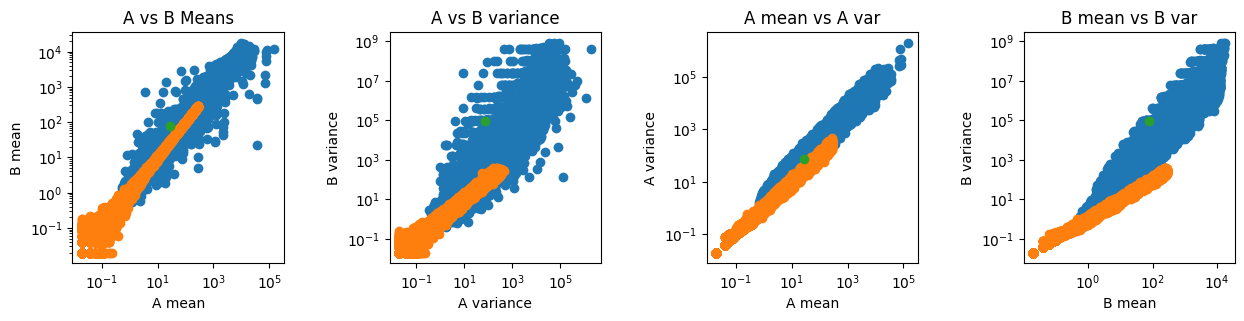

In [6]:
fig, axs = plt.subplots(1,4, figsize = (15,3))

axs[0].scatter(res_spo[:,0],res_spo[:,1])
axs[0].scatter(res_ind[:,0],res_ind[:,1])
axs[0].scatter(truth[0],truth[1])
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_title('A vs B Means')
axs[0].set_xlabel('A mean')
axs[0].set_ylabel('B mean')


axs[1].scatter(res_spo[:,2],res_spo[:,3])
axs[1].scatter(res_ind[:,2],res_ind[:,3])
axs[1].scatter(truth[1],truth[3])
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_title('A vs B variance')
axs[1].set_xlabel('A variance')
axs[1].set_ylabel('B variance')

axs[2].scatter(res_spo[:,0],res_spo[:,2])
axs[2].scatter(res_ind[:,0],res_ind[:,2])
axs[2].scatter(truth[0],truth[2])
axs[2].set_yscale('log')
axs[2].set_xscale('log')
axs[2].set_title('A mean vs A var')
axs[2].set_xlabel('A mean')
axs[2].set_ylabel('A variance')

axs[3].scatter(res_spo[:,1],res_spo[:,3])
axs[3].scatter(res_ind[:,1],res_ind[:,3])
axs[3].scatter(truth[1],truth[3])
axs[3].set_yscale('log')
axs[3].set_xscale('log')
axs[3].set_title('B mean vs B var')
axs[3].set_xlabel('B mean')
axs[3].set_ylabel('B variance')

plt.subplots_adjust(wspace = 0.5)

## Function to get the Posterior Distribution
Now, lets create a function that will create our posterior distribution. This function will take as inputs the mutation rates used to generate the simulated data, the values for the observed data, the simulated data, and lastly a threshold `e` which will be used to determine which simulations we choose to accept. This function works by simply calculating the euclidean distances between all simulation runs and the truth value, determining the bottom `e`-percentile (i.e. the closest to the observed), and then returning the values for mutation rate that generated teh data closest to the truth.

In [7]:
def get_post(params, point, sims, e):
    distances = np.linalg.norm(point - sims, axis = 1)
    thresh = np.percentile(distances, e)
    return params[distances < thresh]

## Cross-validation for model selection

To evaluate if ABC can, at all, distinguish between the two models, we perform a cross-validation for model selection via leave-one-out cross-validation. Here, we randomly take summary statistics of one simulation replicate as a pseudo-observation, and its parameter is estimated with the rejecting algorithm using all other simulations. This is repeated nval = 100 times, and numbers of classifications are summarised in a confusion matrix.

In [8]:
e = 0.5 #our threshold parameter 
models = np.array(['spo']*num_sims + ['ind']*num_sims) #creating an array to keep track of which sim was from which model
all_sims = np.concatenate((res_spo,res_ind)) #big array of all sims

spo_cvs = 0
for i in range(100):
    #selecting a simluation to be the "truth"
    sim_truth = all_sims[i,:]
    #Removing that sim and its model from the rest of the simulations and models array
    sims_other = np.concatenate((all_sims[:i,:],all_sims[i + 1:,:]))
    models_other = np.concatenate((models[:i],models[i + 1:]))
    #calculating the posterior for the two models (i.e. how many sims from either model fall within the threshold for our "truth"
    model_post = get_post(models_other,sim_truth,sims_other,e) 
    spo_within = (model_post == 'spo').sum()
    ind_within = (model_post == 'ind').sum()
    #for the 100 iterations, we tally how many times the number is larger for the correct model
    if spo_within > ind_within:
        spo_cvs += 1


ind_cvs = 0
for i in range(100): #well do the same for the other model 
    j = i + num_sims
    #selecting a simluation to be the "truth"
    sim_truth = all_sims[j,:]
    #Removing that sim and its model from the rest of the simulations and models array
    sims_other = np.concatenate((all_sims[:j,:],all_sims[j + 1:,:]))
    models_other = np.concatenate((models[:j],models[j + 1:]))
    #calculating the posterior for the two models (i.e. how many sims from either model fall within the threshold for our "truth"
    model_post = get_post(models_other,sim_truth,sims_other,e) 
    spo_within = (model_post == 'spo').sum()
    ind_within = (model_post == 'ind').sum()
    #for the 100 iterations, we tally how many times the number is larger for the correct model
    if spo_within < ind_within:
        ind_cvs += 1
        
pd.DataFrame([[ind_cvs,100-ind_cvs], [100-spo_cvs,spo_cvs]], columns = ['Ind','Spo'], index = ['Ind','Spo'])

NameError: name 'models_other' is not defined

In the confusion matrix, the j-th column of the i-th row is the number of times that the i-th model were classified as the j-th model. If our model selection is working, then our confusion matrix will show that if the "truth" is the induced model, the value in the `Ind` row for the `Ind` column should be greater than the value for the `Spo` column. Likewise for the `Spo` row, if the "truth" is the spontaneous model, then the value in the `Spo` column should be greater than in the `Ind` column. It looks like ABC is working well for model selection!

## Model selection
Now, let’s perform model selection with ABC

In [159]:
# Model Selection
e = 0.5
posterior_model = get_post(models,truth,all_sims,e)

print('% Spo',(posterior_model == 'spo').sum()/len(posterior_model))
print('% Ind',(posterior_model == 'ind').sum()/len(posterior_model))

% Spo 1.0
% Ind 0.0


Looks like the spontaneous model got 100% support! 

## Cross Validation for parameter inference 
Now that we know which model is most likely, we can see how well ABC can do parameter inference on the simulated data. Again we will use cross validation for this. The idea again is to pick a simulation to be our "truth" and perform ABC parameter inference using the other simulations. We can then check how well ABC is able to recover the value by plotting the log transformed mutation rates and calculating $R^2$.

R^2 = 0.9124637827646673


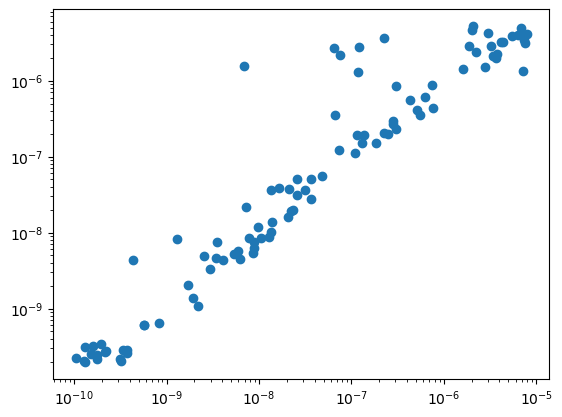

In [168]:
# CV for parameter inference 
e = 0.5

spo_ests = []
for i in range(100):
    #picking a simulation to be the "truth"
    sim_truth = res_spo[i,:] 
    #removing that sim from all others
    sim_other = np.concatenate((res_spo[:i,:],res_spo[i+1:,:]))
    mu_other = np.concatenate((mus[:i],mus[i+1:]))
    # calculating the posterior distribution 
    posterior = get_post(mu_other,sim_truth,sim_other,e)
    # estimating the parameter as the mean of the distribution
    estimate = posterior.mean()
    spo_ests.append(estimate)

plt.scatter(mus[:100],spo_ests)
plt.yscale('log')
plt.xscale('log')

print('R^2 =',stats.pearsonr(np.log(mus[:100]), np.log(spo_ests))[0]**2)

Looks like our method does a pretty good job of parameter estimation! So lets do it with the observed data

3.1460623561058334e-08


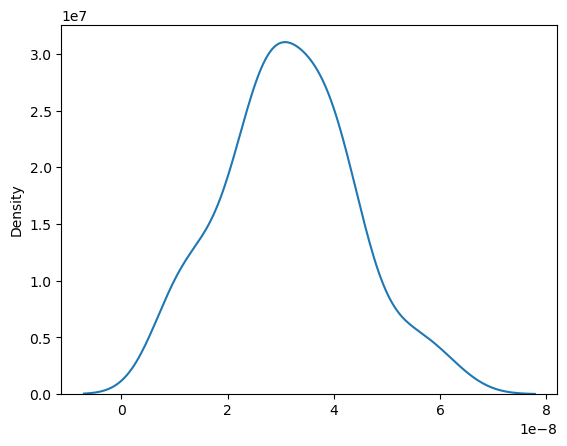

In [163]:
# Parameter Inference
e = 0.5
post = get_post(mus,truth,res_spo,e)
sns.kdeplot(post)
print(np.mean(post))

It worked!!

## Posterior predictive check

Now we should check to see if the posterior distribution would actually produce data like we observed. This is called a posterior predictive check, and the idea is to generate a distribution of model values (in this case the means and variances for parts A and B) and check to see that these distributions matched our obseved value. We can do this by simply drawing a mutation rate from our posterior distribution at random for 1000 simulations.

In [180]:
ppc = np.empty((1000,4))
for i in tqdm(range(1000)):
    mu = np.random.choice(post)
    ppc[i,:] = sim_ld(T = T, mu = mu, n_0 = n_0, n_sample = n_sample, r = r).simulate_spo_model()

100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 138.85it/s]


Plotting our observed values (red lines) along-side the distributions from our new simulated values shows us that our posterior distribution and model predicts our observed data well.

Text(0.5, 1.0, 'Variance B')

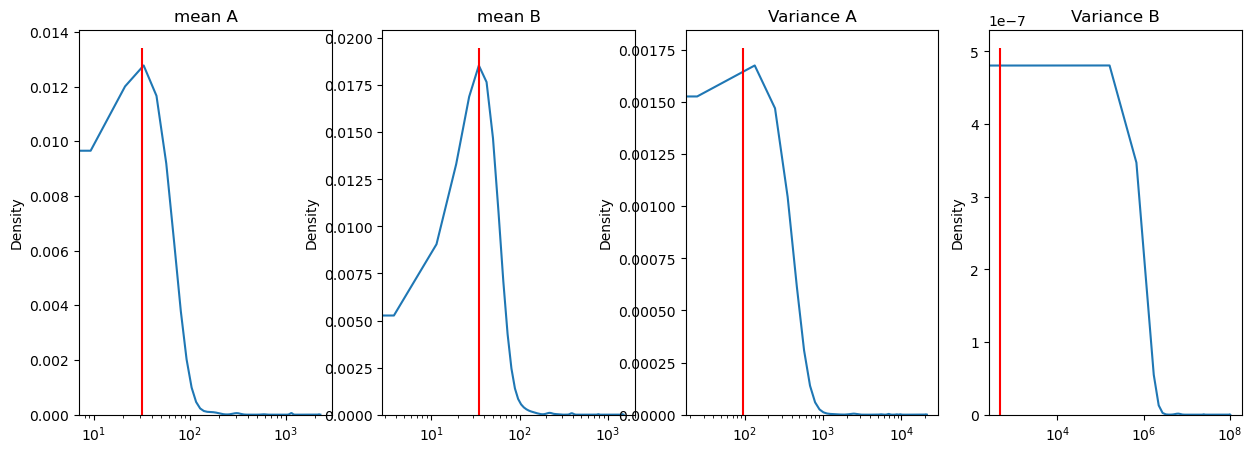

In [195]:
fig, axs = plt.subplots(1,4, figsize = (15,5))

for i, ax in enumerate(axs):
    sns.kdeplot(ppc[:,i],ax = ax)
    ax.set_xscale('log')
    ax.vlines(truth[i],ax.get_ylim()[0],ax.get_ylim()[1], color = 'red')
    
axs[0].set_title('mean A')
axs[1].set_title('mean B')
axs[2].set_title('Variance A')
axs[3].set_title('Variance B')